In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

from base_rl.eval_policy import EvalDiscreteStatePolicy
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from envs.plot import plot_industrial_benchmark_trajectories

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]

## Load Data and MDP Model

In [3]:
#trajectories_samples = ['trajectory_ep1000_model_aeq-20bits2.npy', 'trajectory_ep1000_model_final_h20bits3.npy', 'trajectory_ep1000_model_h_c-20bits3.npy']
trajectories_samples = ['trajectory_ep1000_model_aeq-20bits2.npy']


device = 'cpu'
mdp_save_paths = [f'tmp/duipi/mdp_{file.split(".")[0]}.pkl' for file in trajectories_samples]
model_names = [''.join(file.split(".")[0].split('ep')[-1].split('_', maxsplit=1)[-1]) for file in trajectories_samples]
quant_models_paths = [f'tmp/state_quantization/{model_name}' for model_name in model_names]
policies_save_paths = [f'tmp/duipi/ib_policy_{file.split(".")[0]}.pkl' for file in trajectories_samples]

## Create MDP Models

In [4]:
from dynamic_programming.mdp_model import create_mdp_models

for i, sample_file in enumerate(trajectories_samples):
    load_path = os.path.join("tmp", "offline_rl_trajectories", sample_file)
    create_mdp_models(load_path=load_path, mdp_save_path=mdp_save_paths[i], reward_function_type='state_action_state', device=device, calc_reward_variance=True,reward_offset=2000)

tmp/duipi/mdp_trajectory_ep1000_model_aeq-20bits2.pkl
-343.3163587184372
1000000
3737
Computing Transition Model
Computing Reward Function


In [5]:
from duipi.train import DUIPITrainer

for i, mdp_save_path in enumerate(mdp_save_paths):
    print(trajectories_samples[i])
    mdp_model = MDPModel.load(mdp_save_path)
    solver = DUIPITrainer(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                         count_state_action=mdp_model.count_state_action, xi=0.5, gamma=0.99, variance_R=mdp_model.reward_variance,count_state_action_state=mdp_model.count_state_action_state)
    solver.train(epochs=500)
    trained_policy = DPPolicy(policy_table=solver.get_policy(), state_to_index=mdp_model.state_to_index,
                              index_to_action=mdp_model.index_to_actions)
    trained_policy.save(policies_save_paths[i])

trajectory_ep1000_model_aeq-20bits2.npy


/home/hamza/PycharmProjects/StateCompression/duipi/train.py:58: RuntimeWarning: invalid value encountered in divide
  uncertainty_p[:, :, state] = self.transition_model[:, :, state] * (


Epoch: 1
Old vs New policy difference: 404592.11239619093
Epoch: 2
Old vs New policy difference: 404717.7575750687
Epoch: 3
Old vs New policy difference: 401576.9483879039
Epoch: 4
Old vs New policy difference: 398254.14201046975
Epoch: 5
Old vs New policy difference: 394839.2097094574
Epoch: 6
Old vs New policy difference: 391321.7363253064
Epoch: 7
Old vs New policy difference: 387761.47421000997
Epoch: 8
Old vs New policy difference: 384185.0248146866
Epoch: 9
Old vs New policy difference: 380603.5024364154
Epoch: 10
Old vs New policy difference: 377058.35415121075
Epoch: 11
Old vs New policy difference: 373557.1752199971
Epoch: 12
Old vs New policy difference: 370042.3999695726
Epoch: 13
Old vs New policy difference: 366530.6599988464
Epoch: 14
Old vs New policy difference: 363052.90056996193
Epoch: 15
Old vs New policy difference: 359616.23006204213
Epoch: 16
Old vs New policy difference: 356236.8750509587
Epoch: 17
Old vs New policy difference: 352891.24146345427
Epoch: 18
Old vs

Tag: ib_policy_trajectory_ep1000_model_aeq-20bits2
Episode 9 Reward: -233.5576100665298 || New State Found: False


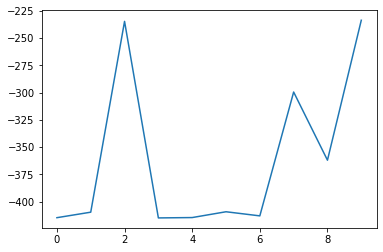

Reward Mean: -360.5426505426648
Reward std : 72.14985570557515


In [6]:
from benchmarks.policy_benchmarks import PolicyBenchmarks

steps_per_episode = 1000
evaluators = []
for i, policy_file in enumerate(policies_save_paths):
    eval_policy = DPPolicy.load(policy_file)
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device, 'model_path': quant_models_paths[i]}
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=env_kwargs,
                                        tag=policy_file.split('/')[-1].split('.')[0])
    evaluators.append(evaluator)

policy_benchmarks = PolicyBenchmarks(evaluators=evaluators, epochs=10)
policy_benchmarks.benchmark()

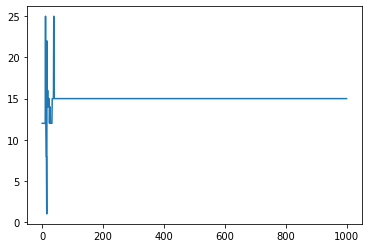

In [7]:
plt.plot(policy_benchmarks.evaluators[-1].eval_trajectories[0]['actions'])

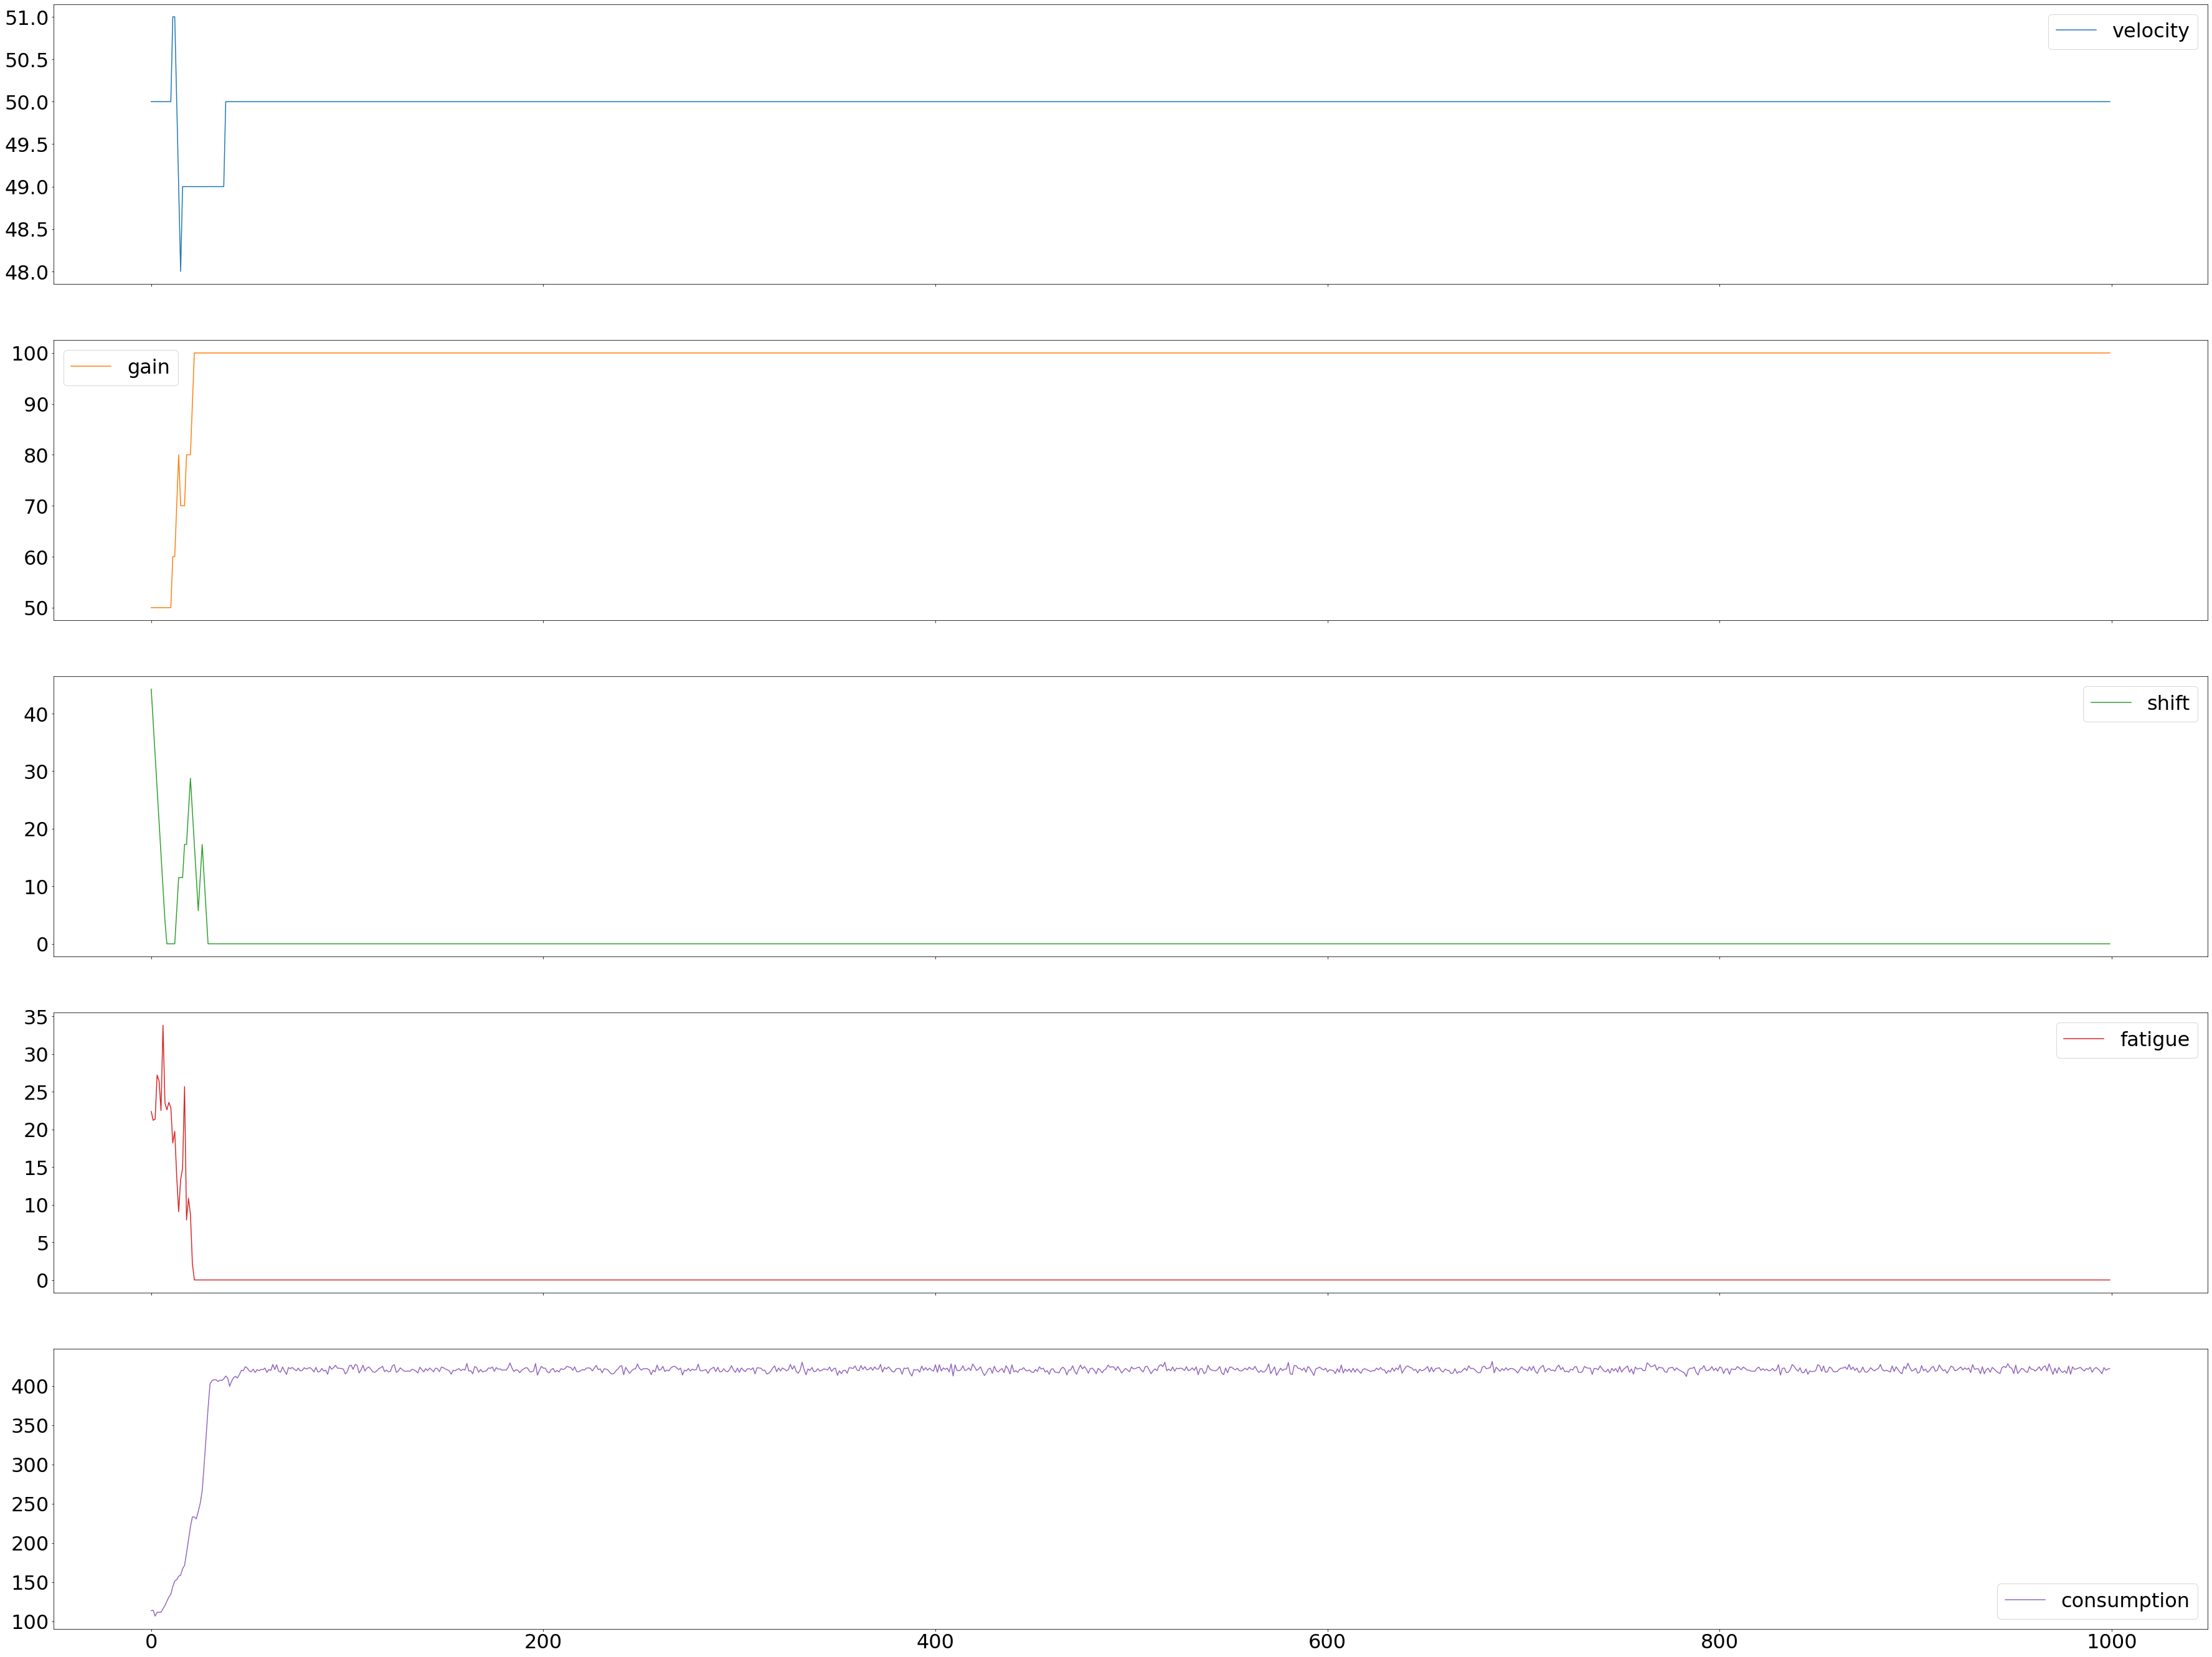

In [8]:
plot_industrial_benchmark_trajectories(policy_benchmarks.evaluators[-1].eval_trajectories[0]['info'])

In [9]:
df = pd.DataFrame(policy_benchmarks.benchmark_metrics)
df.T

,reward,std
ib_policy_trajectory_ep1000_model_aeq-20bits2,-360.542651,72.149856
